In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

import numpy as np
from scipy.optimize import minimize
import copy

import pandas as pd

In [2]:
np.random.seed(0)

class CompresedSensingInterpolator():
    def __init__(self):
        self.dataMean = None
        self.timeSeriesLength = None

    def _normalize(self, data):
        mean = np.nanmean(data)
        self.dataMean = mean
        data = data - self.dataMean
        return data

    def _denormalize(self, data):
        if self.dataMean == None: # if _normalize hasn't been called yet
            return data
        data = data + self.dataMean
        return data

    def _getDesignMatrix(self, ts, numBases):
        A = []
        # sample up to the nyquist frequency
        omegas = np.linspace(1, self.timeSeriesLength // 2, numBases)
        print("creating desing matrix")
        loop = tqdm(total = omegas.shape[0])
        for omega in omegas:
            bi_r = np.cos(omega * ts)
            bi_i = np.sin(omega * ts)

            A.append(bi_r)
            A.append(bi_i)
            loop.update()
        loop.close()

        A = np.array(A).T

        return A

    def _getDataWithoutNones(self,dataWithNones, ts):
        '''
        use all the data that is not None
        '''
        mask = np.isnan(dataWithNones)
        dataWithNones = np.array(dataWithNones)
        data = dataWithNones[~mask]

        tsWithoutNones = ts[~mask]
        return data, tsWithoutNones

    def _getTs(self, dataWithNones):
        '''
        frame the whole time series as occuring across 2 pi
        (this makes the math for basis functions easy)
        '''
        self.timeSeriesLength = dataWithNones.shape[0]
        ts = np.linspace(0, 2 * np.pi, self.timeSeriesLength)
        return ts

    def _predict(self, A, coefficients):
        return A @ coefficients

    def _getFirstGuessOfCoefficients(self, data, A):
        result = np.linalg.lstsq(A, data, rcond=None)
        coefficients = result[0]
        return coefficients

#    def _getL1Norm(self, coefficients):
#        return torch.linalg.norm(coefficients, 1)

    def _getCoefficients(self, dataWithoutNones, tsWithoutNones, numBases, method="SLSQP"):
        A = self._getDesignMatrix(tsWithoutNones, numBases)
        firstGuess = self._getFirstGuessOfCoefficients(dataWithoutNones, A)

        # convert everything over to tensors to user Pytorch
        A = torch.Tensor(A)
        y = torch.Tensor(dataWithoutNones)
        thetas = torch.nn.Parameter(torch.Tensor(firstGuess))

        optimTheta = optim.Adam([thetas], lr=1e-1)

        numSteps = 1000
        lamda = 0.5
        print("optimizing parameters")
        loop = tqdm(total=numSteps)
        for i in range(numSteps):
            # clear the gradient
            optimTheta.zero_grad()

            # make predictions
            yHat = A @ thetas

            # measure loss
            loss1 = torch.linalg.norm(y - yHat, 2) # 2-norm of the error
            loss2 = torch.linalg.norm(thetas, 1) # 1-norm of the parameters
            loss = loss1 + (lamda * loss2)

            # calculate backward pass
            loss.backward()
            optimTheta.step()
            loop.update()
        loop.close()

        coefficients = thetas.detach().numpy()

        return coefficients


    def _getReconstruction(self, coefficients, dataWithNones, ts, numBases, ys):
        # only model the missing times
        mask = np.isnan(dataWithNones)
        tsWithNones = ts[mask]
        A = self._getDesignMatrix(tsWithNones, numBases)
        reconstructedMissingData = self._predict(A, coefficients)
        reconstructedFullData = copy.copy(dataWithNones)
        reconstructedFullData[mask] = reconstructedMissingData
        return reconstructedFullData

    def interpolate(self, dataWithNones, numBases=100, ys=None, method="SLSQP"):
        '''
        uses compressed sensing to interpolate missing data

        numBases: the number of fourier basis functions to use
        when building the interpolation model. More = more accurate.
        '''
        normalizedDataWithNones = self._normalize(dataWithNones)

        ts = self._getTs(normalizedDataWithNones)
        dataWithoutNones, tsWithoutNones = self._getDataWithoutNones(normalizedDataWithNones, ts)
        coefficients = self._getCoefficients(dataWithoutNones, tsWithoutNones, numBases, method=method)
        normalizedReconstruction = self._getReconstruction(coefficients, normalizedDataWithNones, ts, numBases, ys)

        reconstruction = self._denormalize(normalizedReconstruction)

        return reconstruction

In [3]:
def riverTempPlot(df):
    all_days = pd.date_range(df['DateTime'].min(), df['DateTime'].max(), freq='1H')
    all_days = pd.DataFrame(all_days, columns=["DateTime"])
    ys = all_days.merge(df, on='DateTime', how='left')

    ysMissing = ys.iloc[::10, :] #sampling only every second measurment to save on memory
    ysMissing = np.asarray(ysMissing['Temp'])

    method="SLSQP" # "BFGS", etc. see the method paramter here -> https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    numBases = int((ysMissing.shape[0]/2) + 1)
    interpolator = CompresedSensingInterpolator()
    ysComplete = interpolator.interpolate(ysMissing, numBases=numBases, method=method)

    data = {'DateTime': np.asarray(ys.iloc[::10, :]['DateTime']),
            'Missing': ysMissing,
            'Interpolated': ysComplete}
    df_interpolated = pd.DataFrame(data)

    plt.scatter(df_interpolated['DateTime'], df_interpolated['Missing'], label="training data")
    plt.plot(df_interpolated['DateTime'], df_interpolated['Interpolated'], label="interpolated", color='orange')
    plt.legend()
    plt.show()

In [4]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox

class DataFrameFilterApp:
    def __init__(self, root):
        self.root = root
        self.root.title("DataFrame Filter App")

        # Create DataFrame (replace this with your actual DataFrame)
        self.df = pd.read_csv("elwha.cleaned.2000-2023.csv", parse_dates=['DateTime'])

        # Filter options
        self.categories = ['All'] + list(self.df['Site'].unique())
        self.category_var = tk.StringVar()
        self.date_from_var = tk.StringVar()
        self.date_to_var = tk.StringVar()

        # Filter frame
        filter_frame = ttk.LabelFrame(self.root, text="Filter")
        filter_frame.pack(padx=10, pady=10, fill='both', expand=True)

        # Category filter
        category_label = ttk.Label(filter_frame, text="Site:")
        category_label.grid(row=0, column=0, padx=5, pady=5, sticky='e')
        category_combobox = ttk.Combobox(filter_frame, textvariable=self.category_var, values=self.categories, state='readonly')
        category_combobox.grid(row=0, column=1, padx=5, pady=5, sticky='w')

        # Date filter
        date_from_label = ttk.Label(filter_frame, text="From:")
        date_from_label.grid(row=1, column=0, padx=5, pady=5, sticky='e')
        date_from_entry = ttk.Entry(filter_frame, textvariable=self.date_from_var)
        date_from_entry.grid(row=1, column=1, padx=5, pady=5, sticky='w')

        date_to_label = ttk.Label(filter_frame, text="To:")
        date_to_label.grid(row=2, column=0, padx=5, pady=5, sticky='e')
        date_to_entry = ttk.Entry(filter_frame, textvariable=self.date_to_var)
        date_to_entry.grid(row=2, column=1, padx=5, pady=5, sticky='w')

        # Filter button
        filter_button = ttk.Button(filter_frame, text="Filter", command=self.apply_filter)
        filter_button.grid(row=3, columnspan=2, padx=5, pady=10)

    def apply_filter(self):
        # Apply filters
        category_filter = self.category_var.get()
        date_from_filter = self.date_from_var.get()
        date_to_filter = self.date_to_var.get()

        filtered_df = self.df.copy()

        if category_filter != 'All':
            filtered_df = filtered_df[filtered_df['Site'] == category_filter]

        if date_from_filter and date_to_filter:
            try:
                filtered_df = filtered_df[(filtered_df['DateTime'] >= date_from_filter) & (filtered_df['DateTime'] <= date_to_filter)]
            except ValueError:
                messagebox.showerror("Error", "Invalid date format. Please use YYYY-MM-DD.")

        # Display filtered DataFrame (replace this with your display method)
        # print(filtered_df)
        riverTempPlot(filtered_df)

C:\Users\chong\AppData\Local\Temp\ipykernel_13956\1680927238.py:9: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(data)


creating desing matrix


100%|██████████████████████████████████████████████████████████████████████████| 4313/4313 [00:00<00:00, 361453.67it/s]


optimizing parameters


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1442.33it/s]


creating desing matrix


100%|████████████████████████████████████████████████████████████████████████████| 4313/4313 [00:00<00:00, 5517.94it/s]


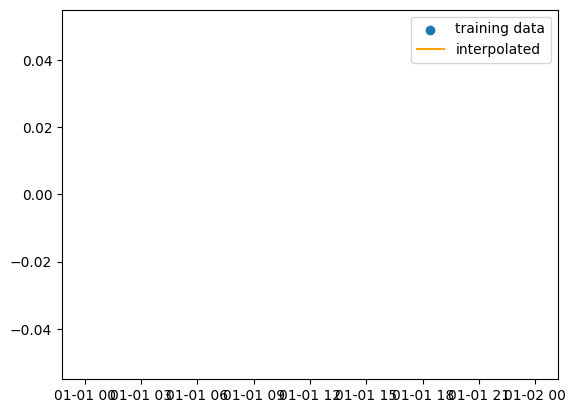

creating desing matrix


100%|██████████████████████████████████████████████████████████████████████████| 4313/4313 [00:00<00:00, 113406.47it/s]


optimizing parameters


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 864.23it/s]


creating desing matrix


100%|████████████████████████████████████████████████████████████████████████████| 4313/4313 [00:00<00:00, 5165.78it/s]


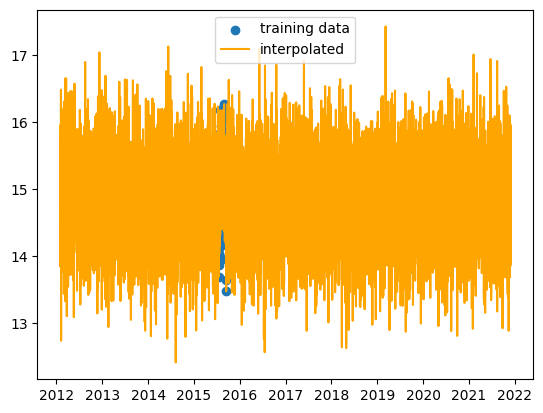

In [5]:
def main():
    root = tk.Tk()
    app = DataFrameFilterApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()